In [1]:
# Step 1: Importing Libraries
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import pickle
import streamlit as st
import os

In [2]:
# Step 2: Load and Clean Dataset
df = pd.read_csv("spam.csv", encoding='latin-1')
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
df.rename(columns={"v1": "target", "v2": "text"}, inplace=True)

In [3]:
# Step 3: Encode Target Column
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df["target"] = encoder.fit_transform(df["target"])

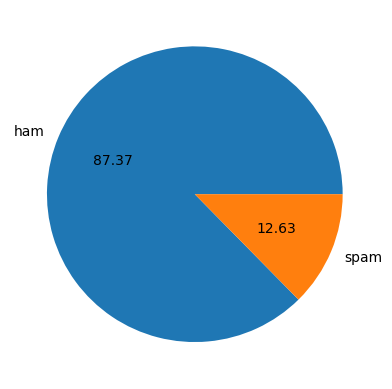

In [4]:
# Step 4: Remove Duplicates and Explore
df.drop_duplicates(inplace=True)
plt.pie(df["target"].value_counts(), labels=["ham", "spam"], autopct="%0.2f")
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


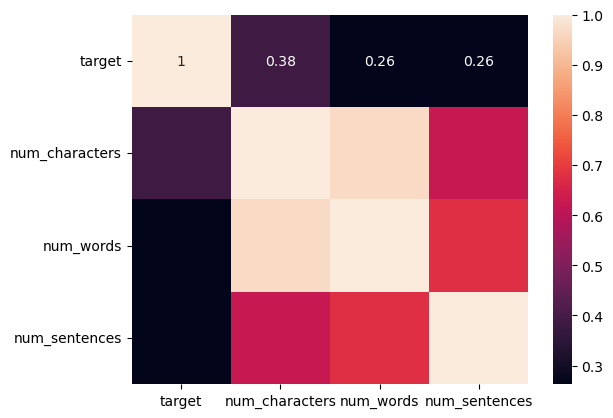

In [5]:
# Step 5: Feature Engineering
nltk.download("punkt")
df["num_characters"] = df["text"].apply(len)
df["num_words"] = df["text"].apply(lambda x: len(nltk.word_tokenize(x)))
df["num_sentences"] = df["text"].apply(lambda x: len(nltk.sent_tokenize(x)))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)
plt.show()

In [6]:
# Step 6: Text Preprocessing with Stemming
nltk.download("stopwords")
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            if i not in stopwords.words("english") and i not in string.punctuation:
                y.append(ps.stem(i))
    return " ".join(y)

df["transformed_text"] = df["text"].apply(transform_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


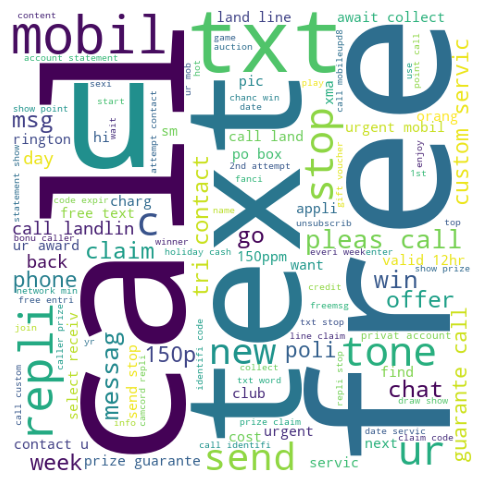

In [7]:
# Step 7: WordClouds and Common Words
wc = WordCloud(width=500, height=500, min_font_size=10, background_color="white")
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(spam_wc)
plt.axis("off")
plt.show()

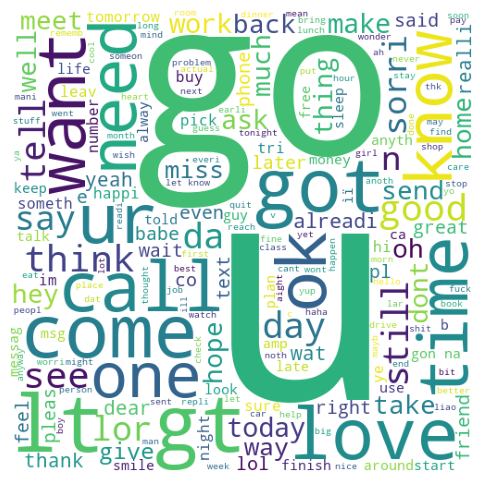

In [8]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(ham_wc)
plt.axis("off")
plt.show()

In [9]:
spam_corpus = [word for msg in df[df["target"] == 1]["transformed_text"] for word in msg.split()]
ham_corpus = [word for msg in df[df["target"] == 0]["transformed_text"] for word in msg.split()]

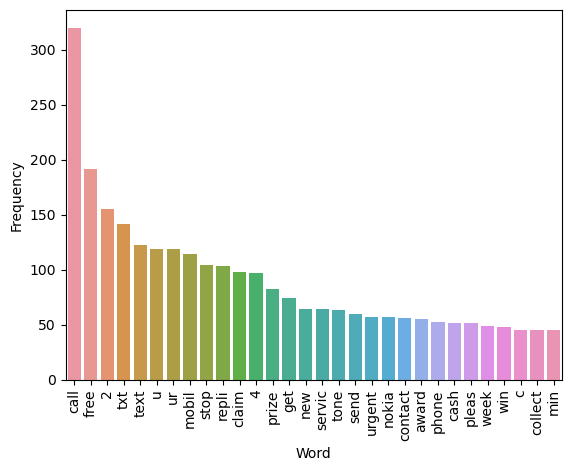

In [10]:
spam_common_words_df = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['Word', 'Frequency'])
sns.barplot(x='Word', y='Frequency', data=spam_common_words_df)
plt.xticks(rotation='vertical')
plt.show()

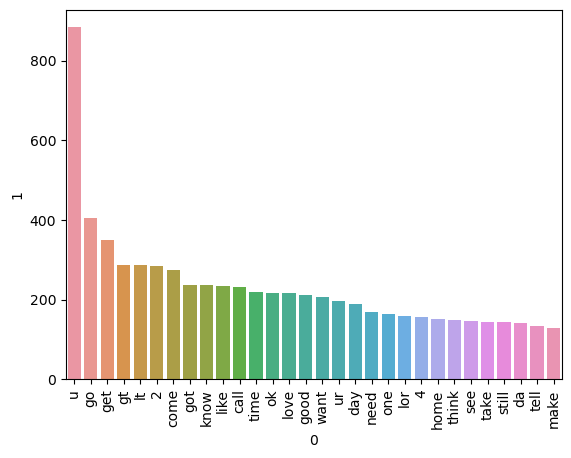

In [11]:
ham_common_words_df = pd.DataFrame(Counter(ham_corpus).most_common(30))
sns.barplot(x=ham_common_words_df[0], y=ham_common_words_df[1])
plt.xticks(rotation='vertical')
plt.show()


In [12]:
# Step 8: Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df["transformed_text"]).toarray()
y = df["target"].values

In [13]:
# Step 9: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


In [14]:
# Step 10: Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

final_model = VotingClassifier(estimators=[('svc', svc), ('mnb', mnb), ('etc', etc)], voting='soft')
final_model.fit(X_train, y_train)


,estimators,"[('svc', ...), ('mnb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,1.0
,coef0,0.0


In [15]:
# Step 11: Evaluation
y_pred = final_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")


Accuracy: 0.9816247582205029
Precision: 0.9917355371900827
Recall: 0.8695652173913043
F1 Score: 0.9266409266409267


In [16]:
import joblib

# Save
os.makedirs("model", exist_ok=True)
with open("model/vectorizer.joblib", "wb") as f:
    joblib.dump(tfidf, f)

with open("model/model.joblib", "wb") as f:
    joblib.dump(final_model, f)
    
# Load
model = joblib.load('model/model.joblib')
vectorizer = joblib.load('model/vectorizer.joblib')


In [17]:
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")

# Load the trained vectorizer and model
tfidf = joblib.load(open("model/vectorizer.joblib", "rb"))
model = joblib.load(open("model/model.joblib", "rb"))

# Text preprocessing function (same as training)
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            if i not in stopwords.words("english") and i not in string.punctuation:
                y.append(ps.stem(i))
    return " ".join(y)

# Example test messages
test_messages = [
    "Congratulations! You've won a $1,000 Walmart gift card. Click the link to claim now!",
    "Hey, are we still on for the meeting tomorrow?",
    "Free entry in 2 a weekly competition to win FA Cup final tickets!",
    "Call me when you're free.",
    "Urgent! Your account is compromised. Click here to reset your password.",
]

# Preprocess and vectorize
transformed_messages = [transform_text(msg) for msg in test_messages]
vectorized_messages = tfidf.transform(transformed_messages)

# Convert sparse matrix to dense for SVC
vectorized_messages_dense = vectorized_messages.toarray()

# Predict using VotingClassifier
predictions = model.predict(vectorized_messages_dense)

# Display predictions
for msg, pred in zip(test_messages, predictions):
    label = "Spam" if pred == 1 else "Not Spam"
    print(f"Message: {msg}\nPrediction: {label}\n")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Message: Congratulations! You've won a $1,000 Walmart gift card. Click the link to claim now!
Prediction: Spam

Message: Hey, are we still on for the meeting tomorrow?
Prediction: Not Spam

Message: Free entry in 2 a weekly competition to win FA Cup final tickets!
Prediction: Spam

Message: Call me when you're free.
Prediction: Not Spam

Message: Urgent! Your account is compromised. Click here to reset your password.
Prediction: Spam



In [21]:
# Step 13: Streamlit Prediction Script
# NOTE: Save the following in a separate file like app.py for deployment
import streamlit as st

# Load model and vectorizer
tfidf = pickle.load(open("vectorizer.pkl", "rb"))
model = pickle.load(open("model.pkl", "rb"))

nltk.download("stopwords")
nltk.download("punkt")
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            if i not in stopwords.words("english") and i not in string.punctuation:
                y.append(ps.stem(i))
    return " ".join(y)

st.title("Email Spam Classifier")
input_sms = st.text_area("Enter your message")

if st.button("Predict"):
    transformed_sms = transform_text(input_sms)
    vector_input = tfidf.transform([transformed_sms])
    result = model.predict(vector_input)[0]
    st.header("Spam" if result == 1 else "Not Spam")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-07-09 20:00:50.533 
  command:

    streamlit run C:\Users\ADMIN\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


# Step 1: Importing Libraries
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
# Step 2: Load and Clean Dataset
df = pd.read_csv("spam.csv", encoding='latin-1')
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
df.rename(columns={"v1": "target", "v2": "text"}, inplace=True)
# Step 3: Encode Target Column
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df["target"] = encoder.fit_transform(df["target"])
# Step 4: Remove Duplicates and Explore
df.drop_duplicates(inplace=True)
plt.pie(df["target"].value_counts(), labels=["ham", "spam"], autopct="%0.2f")
plt.show()
# Step 5: Feature Engineering
nltk.download("punkt")
df["num_characters"] = df["text"].apply(len)
df["num_words"] = df["text"].apply(lambda x: len(nltk.word_tokenize(x)))
df["num_sentences"] = df["text"].apply(lambda x: len(nltk.sent_tokenize(x)))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)
plt.show()
# Step 6: Text Preprocessing with Stemming
nltk.download("stopwords")
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            if i not in stopwords.words("english") and i not in string.punctuation:
                y.append(ps.stem(i))
    return " ".join(y)

df["transformed_text"] = df["text"].apply(transform_text)
# Step 7: WordClouds and Common Words
wc = WordCloud(width=500, height=500, min_font_size=10, background_color="white")
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(spam_wc)
plt.axis("off")
plt.show()
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(ham_wc)
plt.axis("off")
plt.show()
spam_corpus = [word for msg in df[df["target"] == 1]["transformed_text"] for word in msg.split()]
ham_corpus = [word for msg in df[df["target"] == 0]["transformed_text"] for word in msg.split()]
spam_common_words_df = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['Word', 'Frequency'])
sns.barplot(x='Word', y='Frequency', data=spam_common_words_df)
plt.xticks(rotation='vertical')
plt.show()
ham_common_words_df = pd.DataFrame(Counter(ham_corpus).most_common(30))
sns.barplot(x=ham_common_words_df[0], y=ham_common_words_df[1])
plt.xticks(rotation='vertical')
plt.show()
# Step 8: Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df["transformed_text"]).toarray()
y = df["target"].values
# Step 9: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
# Step 10: Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

final_model = VotingClassifier(estimators=[('svc', svc), ('mnb', mnb), ('etc', etc)], voting='soft')
final_model.fit(X_train, y_train)
# Step 11: Evaluation
y_pred = final_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
# Step 12: Save Final Model
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")

# Load the trained vectorizer and model
tfidf = pickle.load(open("vectorizer.pkl", "rb"))
model = pickle.load(open("model.pkl", "rb"))

# Text preprocessing function (same as training)
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            if i not in stopwords.words("english") and i not in string.punctuation:
                y.append(ps.stem(i))
    return " ".join(y)

# Example test messages
test_messages = [
    "Congratulations! You've won a $1,000 Walmart gift card. Click the link to claim now!",
    "Hey, are we still on for the meeting tomorrow?",
    "Free entry in 2 a weekly competition to win FA Cup final tickets!",
    "Call me when you're free.",
    "Urgent! Your account is compromised. Click here to reset your password.",
]

# Preprocess and vectorize
transformed_messages = [transform_text(msg) for msg in test_messages]
vectorized_messages = tfidf.transform(transformed_messages)

# Convert sparse matrix to dense for SVC
vectorized_messages_dense = vectorized_messages.toarray()

# Predict using VotingClassifier
predictions = model.predict(vectorized_messages_dense)

# Display predictions
for msg, pred in zip(test_messages, predictions):
    label = "Spam" if pred == 1 else "Not Spam"
    print(f"Message: {msg}\nPrediction: {label}\n")
# Step 13: Streamlit Prediction Script
# NOTE: Save the following in a separate file like app.py for deployment
import streamlit as st

# Load model and vectorizer
tfidf = pickle.load(open("vectorizer.pkl", "rb"))
model = pickle.load(open("model.pkl", "rb"))

nltk.download("stopwords")
nltk.download("punkt")
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            if i not in stopwords.words("english") and i not in string.punctuation:
                y.append(ps.stem(i))
    return " ".join(y)

st.title("Email Spam Classifier")
input_sms = st.text_area("Enter your message")

if st.button("Predict"):
    transformed_sms = transform_text(input_sms)
    vector_input = tfidf.transform([transformed_sms])
    result = model.predict(vector_input)[0]
    st.header("Spam" if result == 1 else "Not Spam")
